# Devils DFTD 2-Stage Infection

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../')))

In [2]:
import time
import json
import pickle

In [3]:
from gillespy2 import TauHybridCSolver, cleanup_tempfiles

In [4]:
from dask.distributed import Client
from dask import delayed

In [5]:
from Devils_DFTD_2_Stage_Infection import DevilsDFTD2StageInfection
from Simulation import Simulation, devil_pop
from ParameterSweep import ParameterSweep

In [6]:
c = Client(n_workers=8, threads_per_worker=1)

## With Immunity Intervention
### Load existing state

In [7]:
immun_state_path = "../ParameterSweeps/DevilsDFTD2StageInfectionWithImmunityState.p"
if os.path.exists(immun_state_path):
    with open(immun_state_path, "rb") as immun_state_file:
        immun_state = pickle.load(immun_state_file)
    
    # Model
    immun_model = immun_state['model']
    # Simulation
    immun_sim = Simulation.load_state(immun_state['sim'])
    # Parameter Sweep Job
    immun_job = ParameterSweep.load_state(immun_state['job'], batch_size=150, statefile=immun_state_path)
else:
    immun_state = None
    print("No existing immunity state found.")
    
    # Model
    immun_model = DevilsDFTD2StageInfection(devil_pop, interventions="immunity")
    # Simulation
    immun_sim = Simulation(model=immun_model)
    # Parameter Sweep Job
    immun_job = ParameterSweep(model=immun_model, batch_size=150, statefile=immun_state_path)

### Solver

In [8]:
immun_sol = delayed(TauHybridCSolver)(model=immun_model, variable=True, delete_directory=False)

### Simulation

In [9]:
immun_sim.configure(solver=immun_sol)
%time _ = immun_sim.run(use_existing_results=True)

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 10.3 µs


In [10]:
immun_sim.output_dftd_devils_probs(print_probs=True)

DFTD elimination: 100%
Devil extinction: 0%


### Visualize Simulation Results

In [11]:
immun_sim.plot()

### Parameter Sweep

In [12]:
immun_params = [
    {"parameter": "immunity_growth_rate", "range": [0.005, 0.0075, 0.01]},
    {"parameter": "immunity_max_level", "range": [50, 60, 70, 80, 100]},
    {"parameter": "immunity_start", "range": [384, 444, 504]}
]

In [13]:
new_params = immun_job.params != immun_params
%time immun_job.run(solver=immun_sol, params=immun_params)

Running 0 new parameter points in 0 batches with 150 points per batch
Estimated time to completion per batch: 0.0 hrs 0.0 mins 0 secs
Total estimated time to completion: 0.0 hrs 0.0 mins 0 secs
CPU times: user 179 µs, sys: 243 µs, total: 422 µs
Wall time: 359 µs


### Visualize Parameter Sweep Results

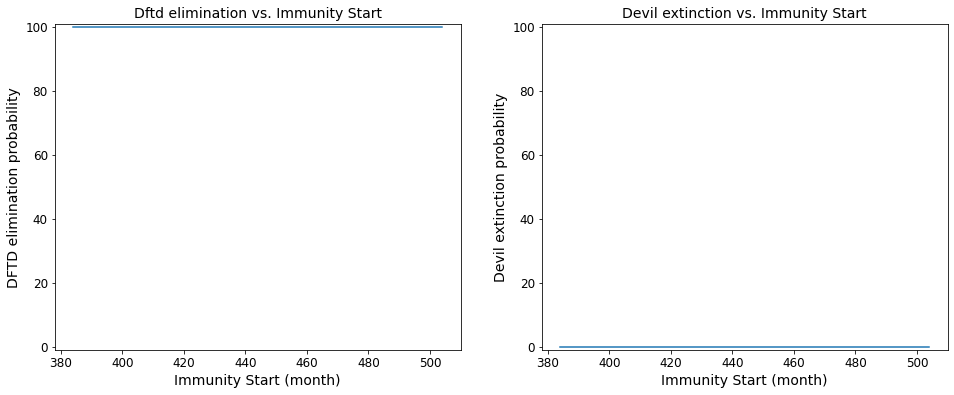

In [14]:
res_sub_keys = ["immunity_max_level:100", "immunity_growth_rate:0.01"]
immun_job.plot_devil_dftd_extinction_over_param(
    res_sub_keys=res_sub_keys, key="immunity_start", param_label="Immunity Start", units="month"
)

In [15]:
immun_job.explore_results()

Output()

### Store Immunity State

In [16]:
immun_state = {"model": immun_model, "sim":immun_sim, "job":immun_job}
with open(immun_state_path, "wb") as immun_state_file:
    pickle.dump(immun_state, immun_state_file)

In [17]:
def get_parameters(job):
    parameters = []
    for param in job.params:
        parameters.append({
            'name': param['parameter'],
            'range': param['range']
        })
    return parameters

In [18]:
def get_probs(job):
    eliminations = {}
    extinctions = {}
    for key, sim in job.results.items():
        eliminations[key] = sim.dftd_elimination
        extinctions[key] = sim.devil_extinction
    return eliminations, extinctions

In [19]:
def generate_prob_data_file(job, state_file):
    eliminations, extinctions = get_probs(job)
    data = {
        'parameters': get_parameters(job),
        'elimination_probs': eliminations,
        'extinction_probs': extinctions
    }
    
    dst = "../figure_data/Fig6A-B-data.json"
    with open(dst, "w") as data_file:
        json.dump(data, data_file, sort_keys=True, indent=4)

In [20]:
generate_prob_data_file(immun_job, immun_state_path)

## Clean Up Solver Files

In [21]:
cleanup_tempfiles()

In [22]:
c.close() # close the dask client